In [23]:
import os
import glob 
import re
import numpy as np
import matplotlib.pyplot as plt
import register as rfn
import ants
import shutil
from PIL import Image
import scipy.misc
from scipy import ndimage
import math
from skimage import io

%load_ext autoreload
%autoreload


# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load zebrafish brain browser images and format 
#-----------------------------------------------------------------------------------
Fzbb = Fdrop + '/' + 'zbrain_stacks/'
zbb1 = ants.image_read(Fzbb + os.sep + 'Misc/huC-h2b-RFP.tif')     
zbb1.set_spacing([.3,.3,1.])
zbb  = (zbb1 / np.amax(zbb1.numpy()))
zbb.set_spacing([.3,.3,1.])

# Generate mean image stack

In [3]:
# Choose fish and make opslist (list of planes to stack together) 
#----------------------------------------------------------------
experiment = 'PTZ-WILDTYPE-01'
condition = 'BLN'
Freg = Ftm + 'Project/' + experiment + '/2photon/sess-01-6dpf/'
os.chdir(Freg)
opslist = sorted(glob.glob('*' + condition + '*ops.npy'))

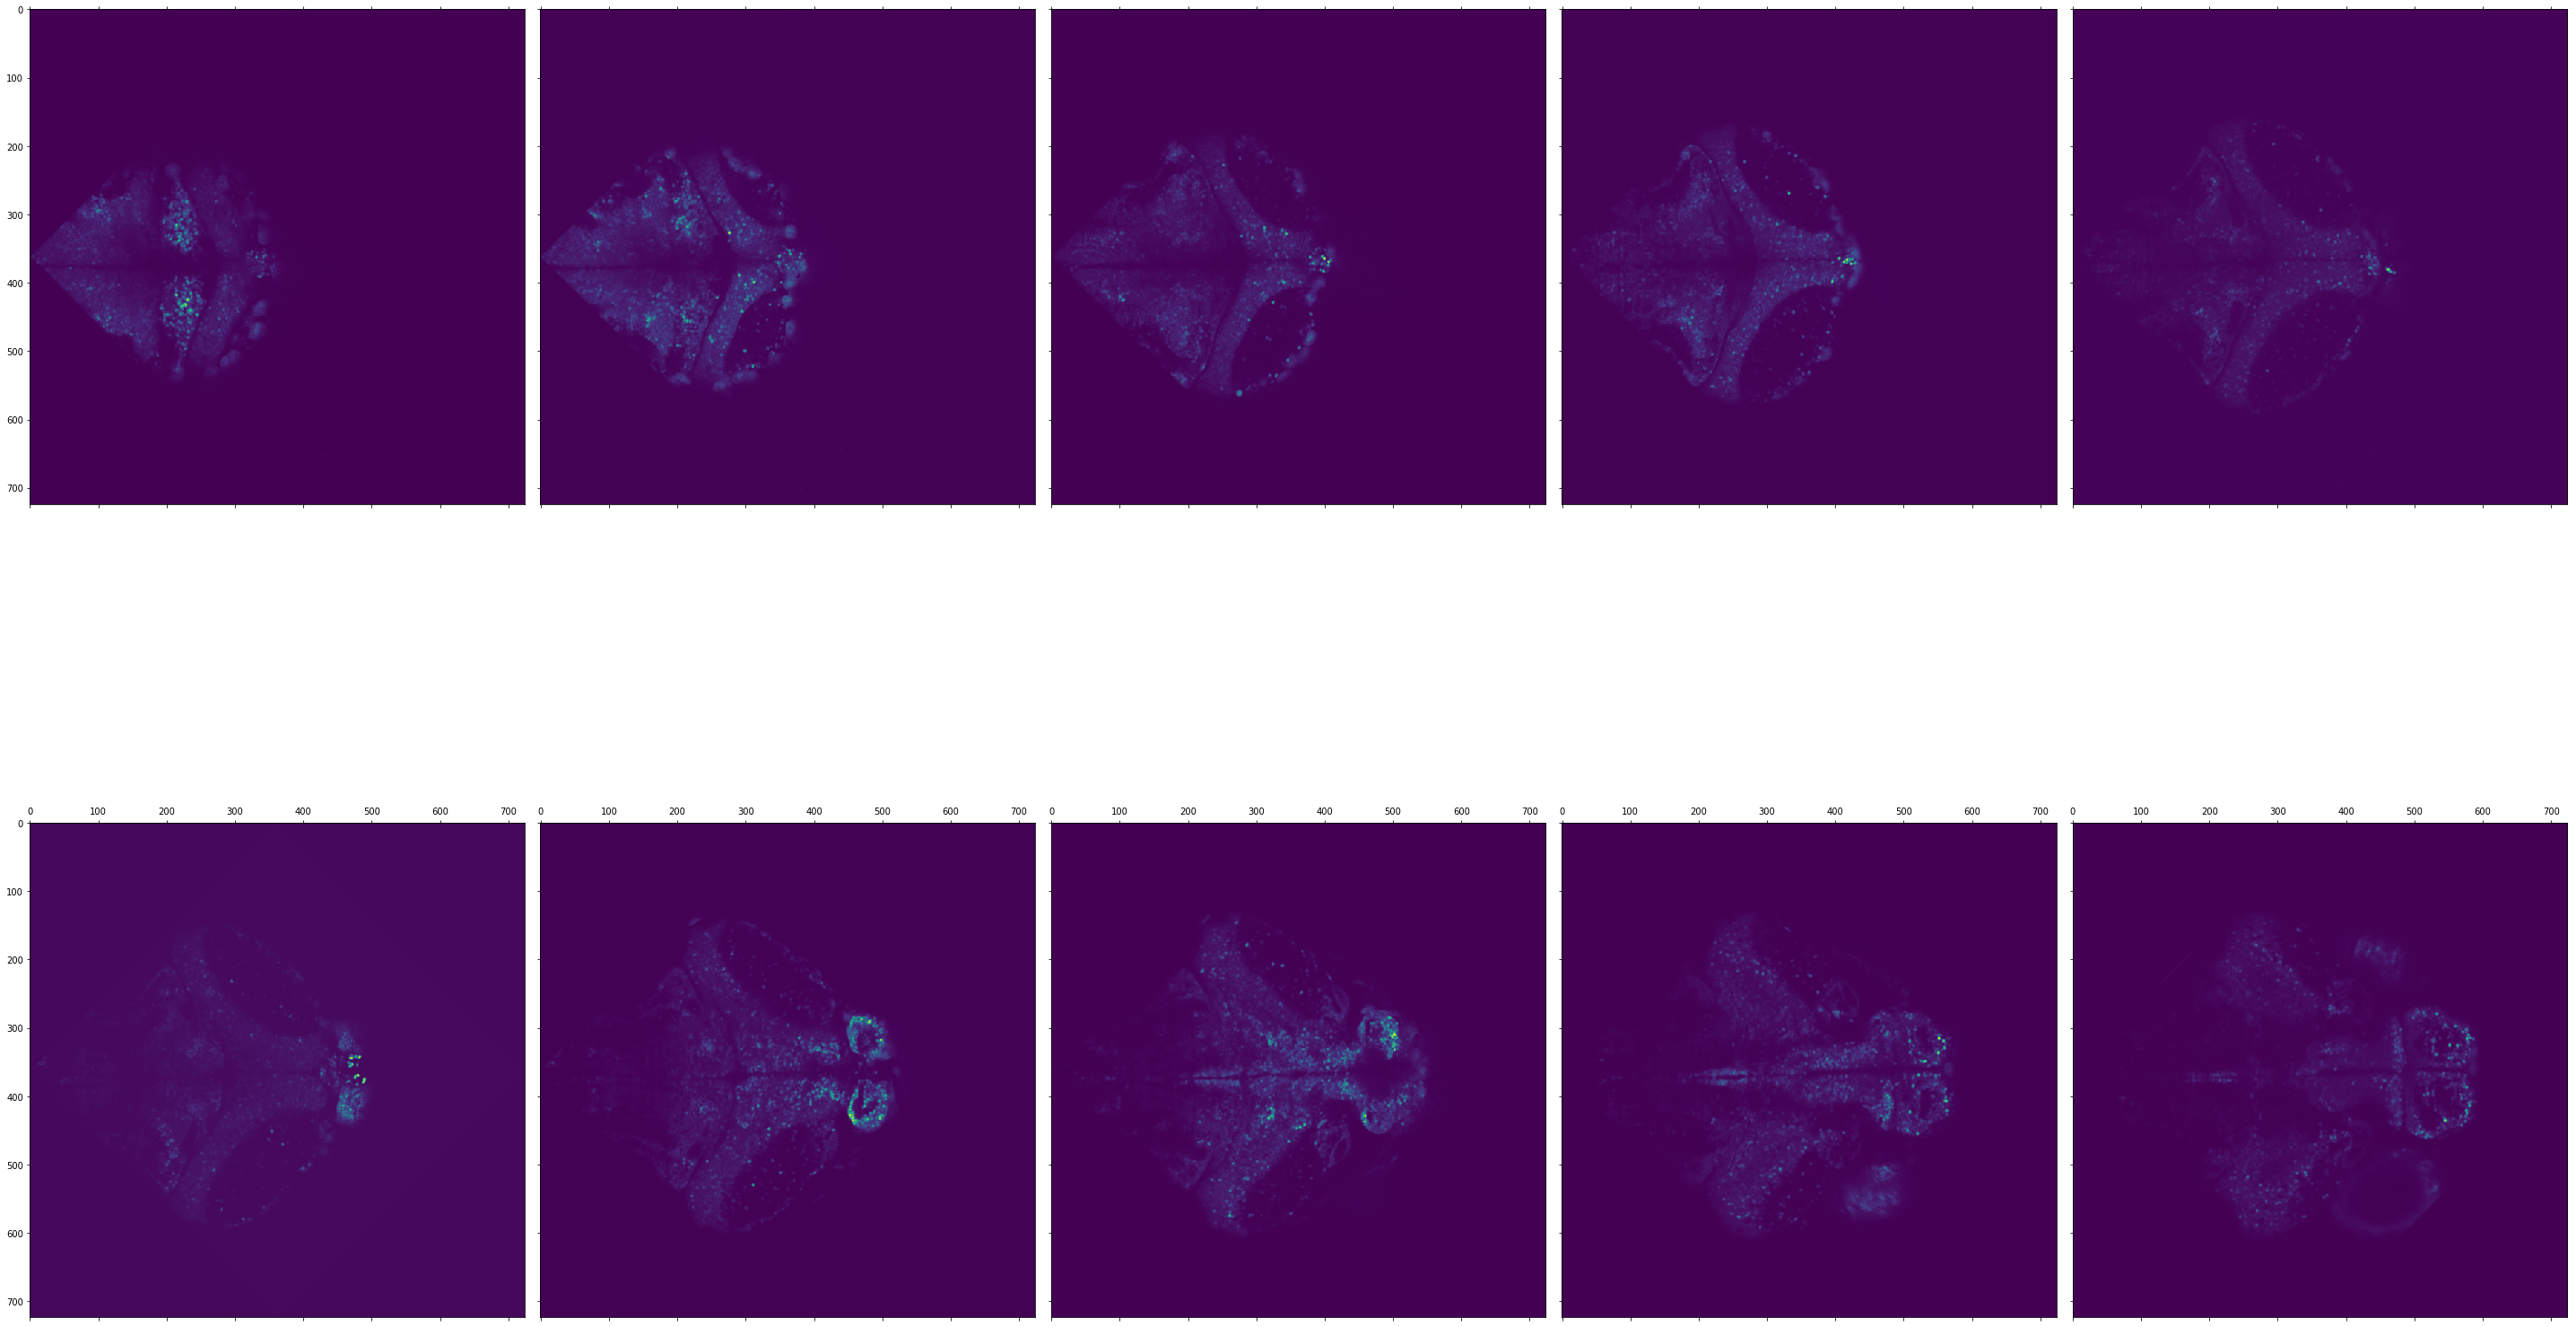

In [16]:
# Rotate image - select correct orientation for registration
#---------------------------------------------------------------------------
Frotate = rfn.rotate(Freg, opslist, degree = 6.75)

In [17]:
# Save as multipage tif - for registration
#-----------------------------------------
Fsavemeanimg = rfn.savemeanimg(Freg, opslist, Frotate)

# Register zbrain to template

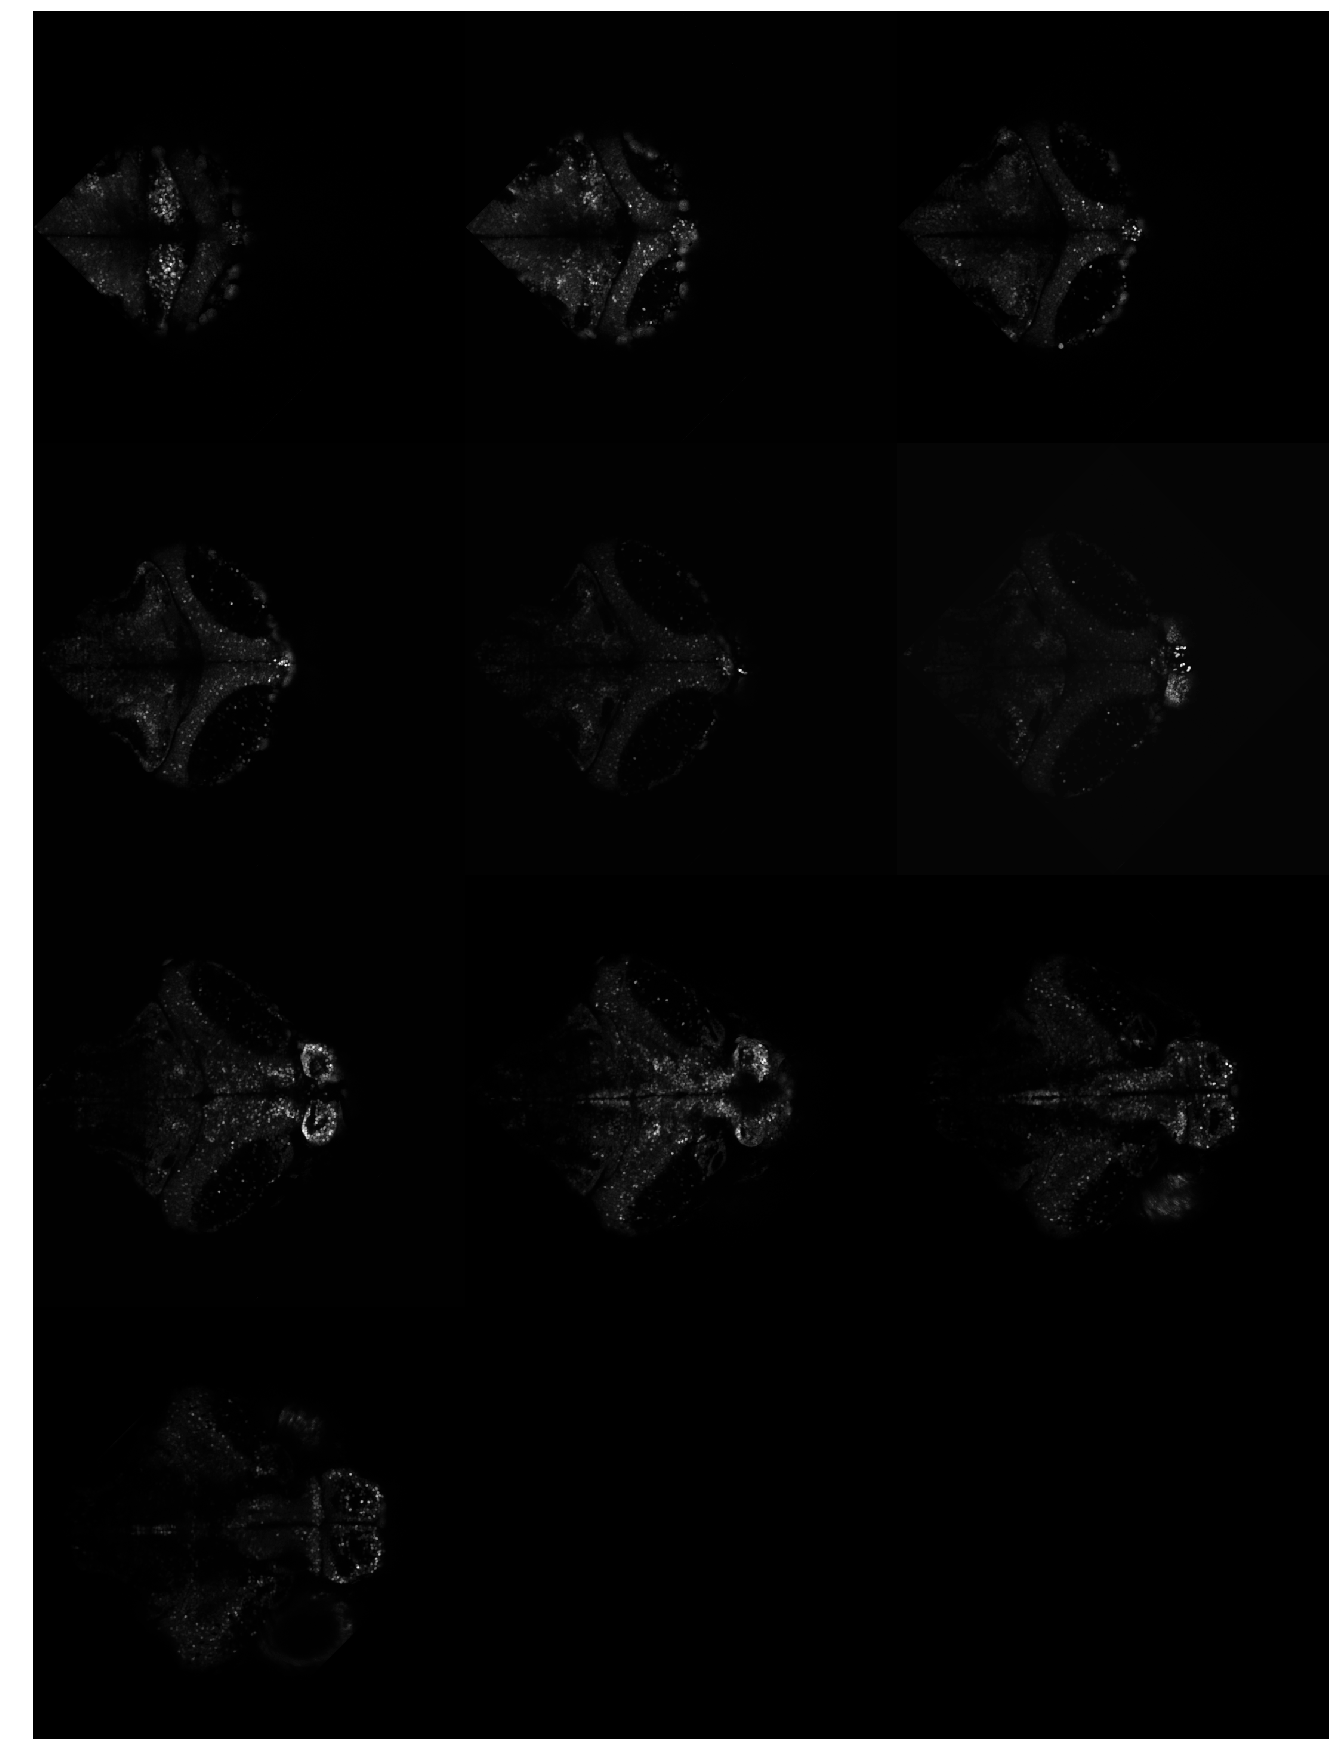

In [18]:
# Choose fish to register
#----------------------------------------------------------------
experiment = 'PTZ-WILDTYPE-01'
condition = 'BLN'
Freg = Ftm + 'Project/' + experiment + '/2photon/sess-01-6dpf/'
os.chdir(Freg)
meanimglist = sorted(glob.glob('*' + condition + '*meanimgstack.tif'))

# Visualise fish
#---------------------------------------------------------------------------
fish2r = ants.image_read(Freg + os.sep + meanimglist[0])
fish2r.set_spacing([.3, .3, 15.])
fish2r.set_direction(np.array([[-1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])) 
rfn.fishplot(fish2r)

In [19]:
#Perform registration - rigid + SyN, sim + Synonly, SyNRA
#?ants.registration - help
#flowsigma: blurring of image for update field; #grad_step: 0.1, steps size in minimising cost functions
#totalsigma: blurring for total field, #aff_sammpling: nbins/radius parameter for syn step
#---------------------------

#STEP1: Rigid - rotation and translation (rigid and sim work the same)
#fish2ref_rigid = ants.registration(zbb, fish2r, type_of_transform = 'Rigid') 
#fish2ref_sim = ants.registration(zbb, fish2r, type_of_transform = 'Similarity') #scaling, rotation and translation

#STEP2: Affine - rigid + scaling (affine + rigid does not work, affine alone works better but worse than step1a)
#flowsigma = 3, grad_step = 0.1, total_sigma = 0/20, aff_sampling = 10
#fish2ref_affine1 = ants.registration(zbb, fish2r, type_of_transform = 'Affine', grad_step = 0.1, flow_sigma = 3, aff_sampling = 10, total_sigma = 0)
#fish2ref_affine2 = ants.registration(zbb, fish2r, type_of_transform = 'Affine', grad_step = 0.1, flow_sigma = 3, aff_sampling = 10, total_sigma = 20)

#STEP3: Symmetric normalisation - deformable transformation
#flowsigma = 4, grad_step = 0.2 (no difference), total_sigma = 0 (no difference), aff_sampling = 10 
fish2ref_synra = ants.registration(zbb, fish2r, type_of_transform = 'SyNRA', grad_step = 0.2, aff_sampling = 10, flow_sigma = 4)

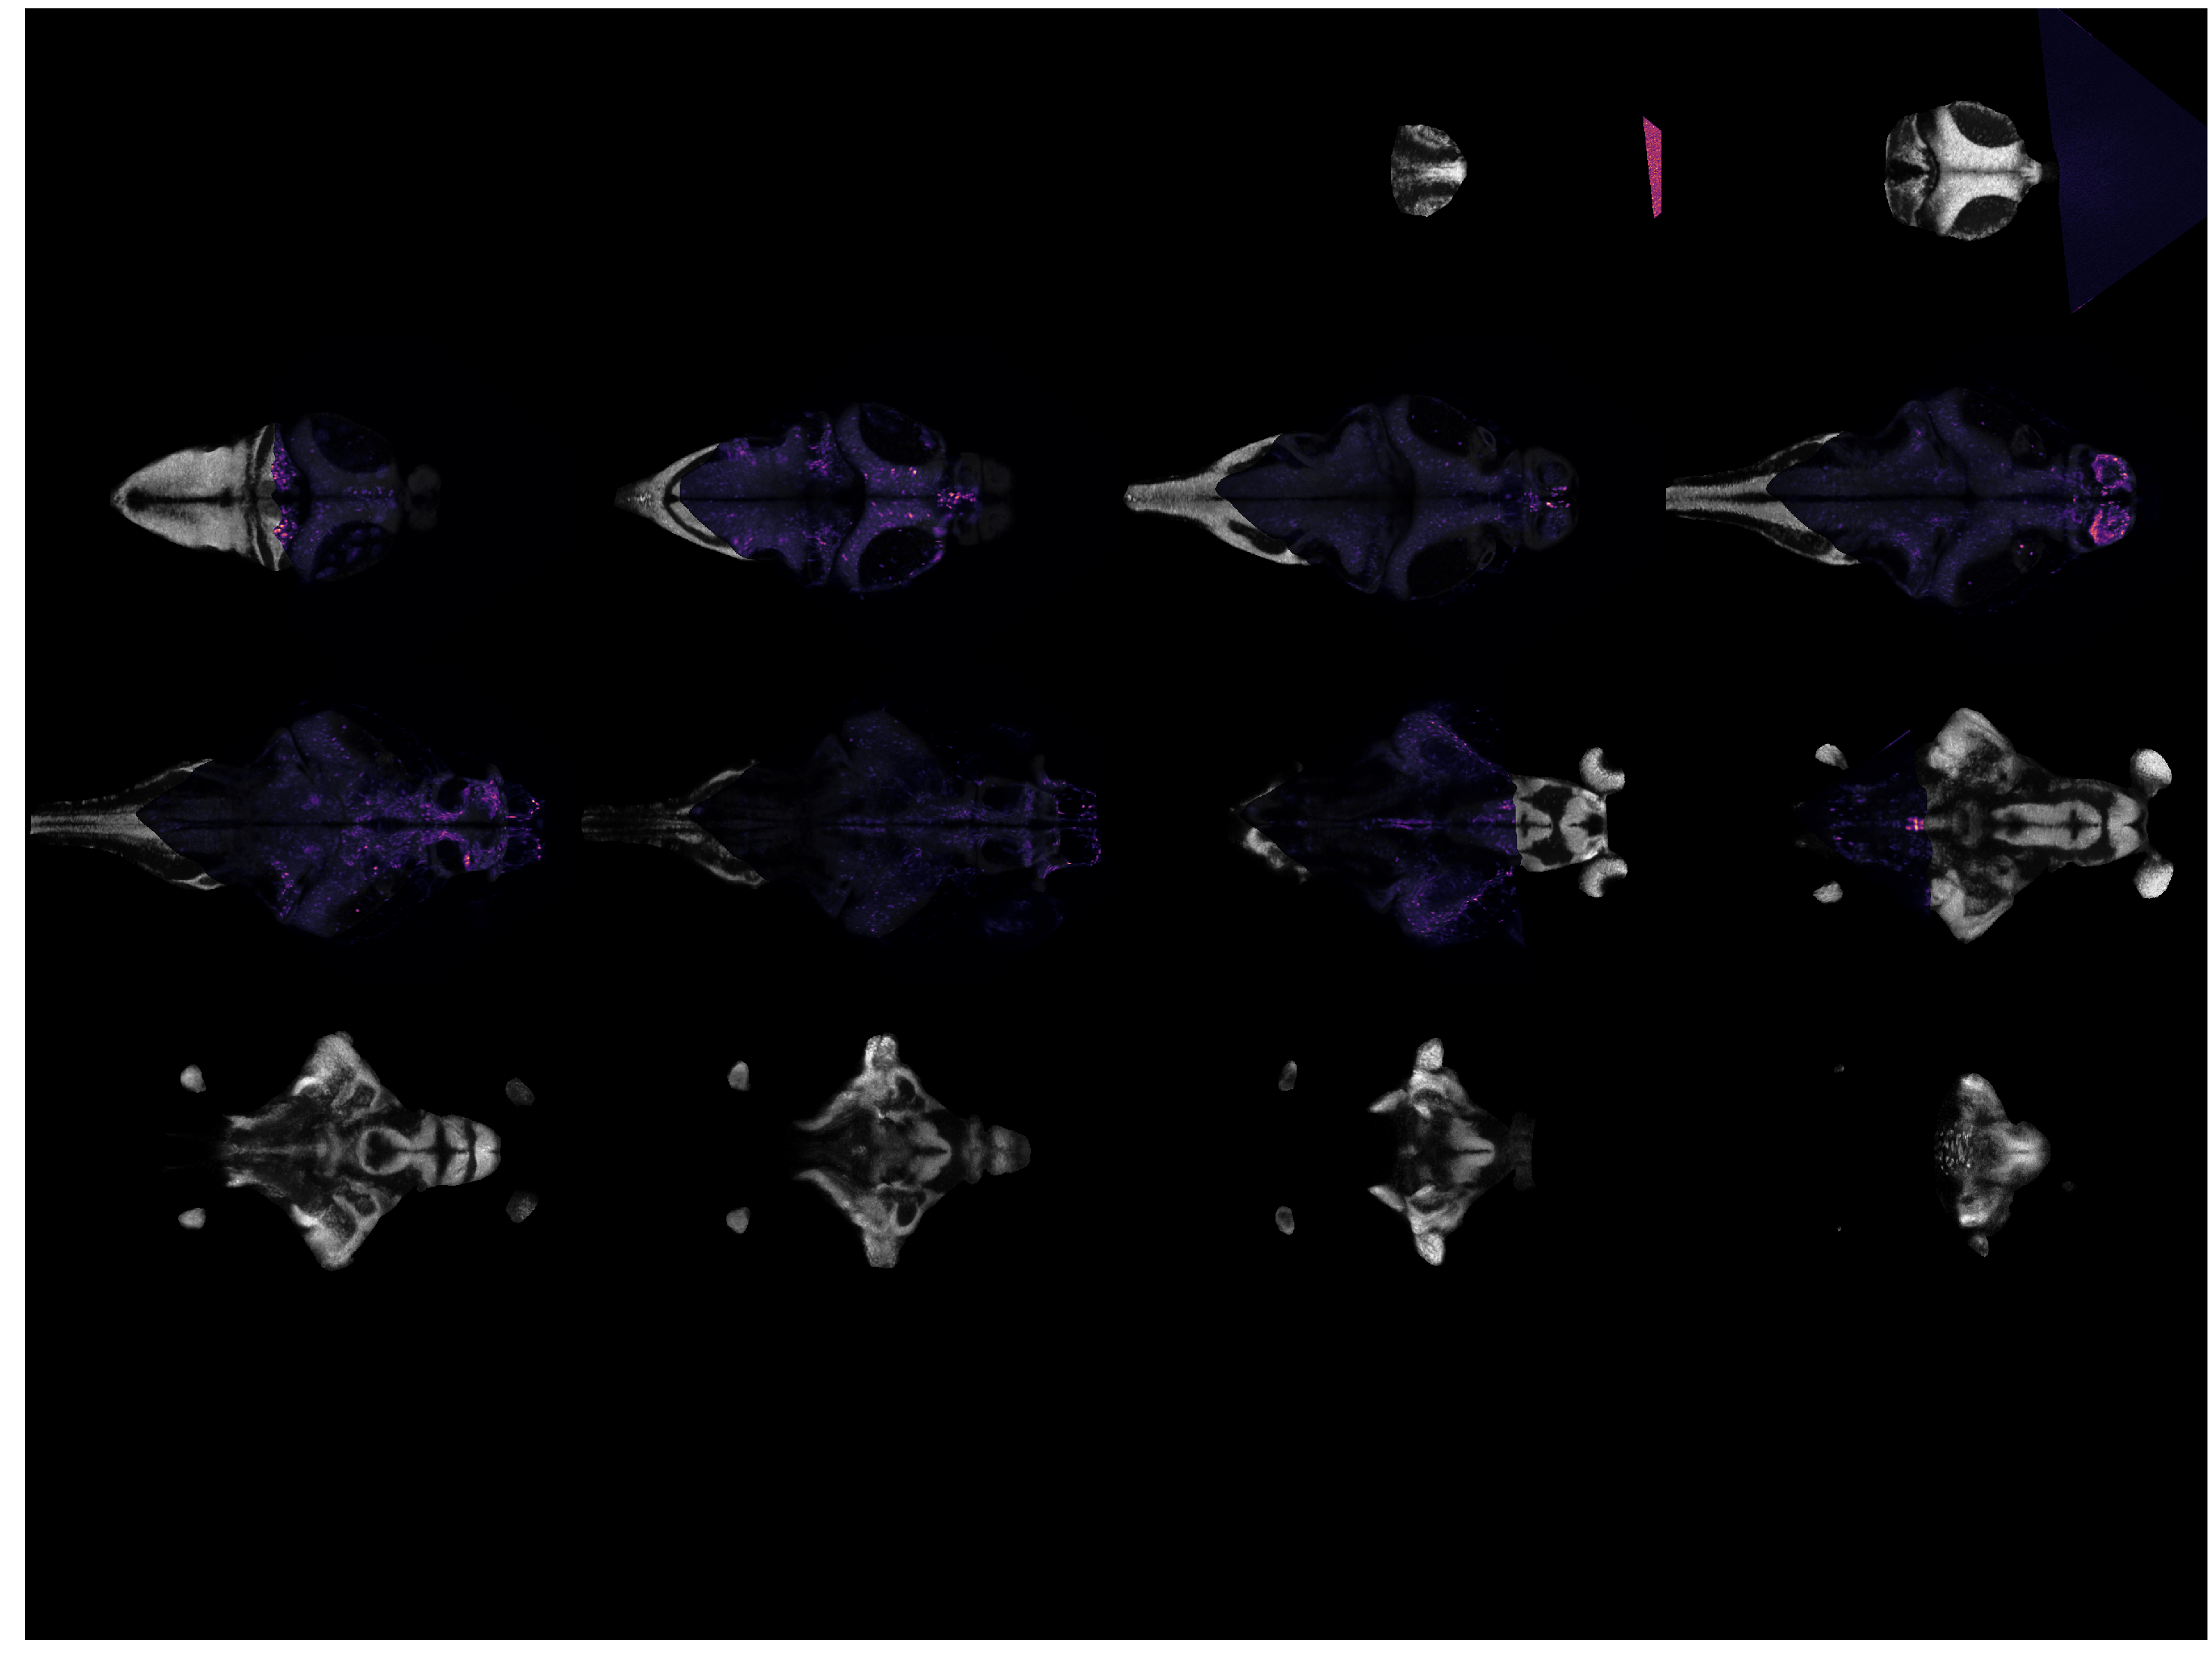

In [22]:
rfn.fishplot(zbb,fish2ref_synra['warpedmovout'], orient = 'axial', al = .9)

# Convert cell coordinates into registered space

# RIP ----- Code Graveyard

In [ ]:
# Manually generate mean img
#----------------------------------------------------------------------
import random as rand
import re

# Generate mean image
#-----------------------------------------------------------------------------------
import random as rand
import re

nrand = 200  #take nrand random images
planes = 10
planelist = list(range(planes))
regvectorlist = list(range(nrand))
regstack = np.zeros((nrand, 262144)) #pixels per image
planecorrvalues = list(range(planes))

#Split into planes
#-----------------------------------------------------------------------------------
for x in range(planes):
    rdm = rand.sample(range(x+1, int(len(tifflist)/10), 10), nrand)
    planelist[x] = rdm  
    
# Find 20 most correlated images per plane 
#-----------------------------------------------------------------------------------
    for i in range(nrand):
        howmany0s = 6 - len(str(planelist[x][i]))
        tiffname = str(planelist[x][i])
        tiffname = tiffname.zfill(len(tiffname) + howmany0s)
        regarray = io.imread(Fmut + '/im_' + tiffname + '.tif')
        regvectorlist[i] = np.concatenate(regarray)   #make into vector 
        regstack [i,:] = regvectorlist[i]
    
    planecorrvalues[x] = np.corrcoef(regstack)

    
#remove self correlated values #python function
#--------------------------------------------------
for x in range(planes):    
    for j in range(planecorrvalues[x].shape[0]):
        for i in range(planecorrvalues[x].shape[0]):
            if planecorrvalues[x][i][j] >0.9:
                planecorrvalues[x][i][j] = 0
                
                
#returns highest 40 correlation values 
#----------------------------------------------------------------
top = []
wll = list(range(planes))
w2ll = list(range(planes))

for x in range(planes): 
    top = planecorrvalues[x] > np.percentile(planecorrvalues[x],99.8) 
    wherelist = list(range(len(top)))
    where2list = list(range(len(top)))
    counter = 0
    
    for j in range(planecorrvalues[x].shape[0]):
        if np.where(top[j] == True)[0].any() > 0:
            wherelist[counter] = planelist[x][j]
            where2list[counter] = np.where(top[j] == True)[0]
            counter+= 1 
    wll[x] = wherelist
    w2ll[x] = where2list

    
    
#initialise vector to fill with frame values
#----------------------------------------------
allimv = np.zeros((planes, np.sum(top)))

for x in range(planes): 
    
    #find final frames that are most correlated
    #----------------------------------------------
    for y in range(allimv.shape[1]):
        vector = np.hstack(w2ll[x])
        allimv[x,y] = planelist[x][vector[y]] #output is array of all most correlated frames per plane - find unique values and average them
        
#plot mean image
#----------------------------------
meanlist = list(range(planes))

for x in range(planes):
    fillme = np.unique(allimv[x])
    means = list(range(len(fillme)))
    for i in range(len(fillme)):
        howmany0s = 6 - len(str(int(fillme[i])))
        tiffname = str(int(fillme[i]))
        tiffname = tiffname.zfill(len(tiffname) + howmany0s)
        loadme = io.imread(Fmut + '/im_' + tiffname + '.tif')
        means[i] = loadme
        
    meanlist[x] = np.mean(means, axis = 0)
    
degree = 9.6
rotimglist = list(range(len(meanlist)))

f, axarr = plt.subplots(2,5, sharey = True, sharex = True, figsize = (40,30))
axarr = axarr.flatten()

for i in range(len(meanlist)):
    rotated_img = ndimage.rotate(meanlist[i], degree*60)
    
    rotimglist[i] = rotated_img
    axarr[i].matshow(rotimglist[i])
    
f.tight_layout()